## Attempting to use CNN and transfer learning to differentiate the different histopathological types of non small cell lung carcinomas (NSCLC) using just CT scans.

Lung cancers may be classified either using the TNM staging( which incorporates the size of the tumor along with the involvement of nearby lymph nodes or other organs) or based on the histopathology of the tumor.

TNM staging is used to characterize the extent of disease whereas the histopathological typing helps us understand the 

Based on the histopathological findings, the NSCLC are divided into 3 major subtypes
1. Adenocarcinoma – Neoplastic gland formation or intracytoplasmic mucin are charcteristic of adenocarcinoma 
2. Squamous cell carcinoma – The presence of keratin production by tumor cells and/or intercellular desmosomes is used
3. Large cell carcinoma – The absence of glandular or squamous differentiation features (ie, poorly differentiated NSCLC, diagnosis of exclusion).

While the TNM staging can be obtained via solely using imaging studies like CT and PET scans, diagnosing the histopathological subtype requires minimally invasive procedures like endobronchial ultrasound-guided transbronchial needle aspiration (EBUS-TBNA) or  transesophageal endoscopic ultrasound fine needle aspiration (EUS-FNA) as a sample of the suspected thoracic mass lesions is required to conduct a histopathological analysis.

This notebook attempted to  differentiate the different histopathological types of lung carcinomas using just CT scans (i.e without invasively taking histopathological samples) via a basic 12 layered CNN and later applies a transfer learning approach with ResNet50 ,a very deep CNN model that has been pre trained using a massive image set called imagenet to try to imporve accuracy.

The basis for this attempt is that there are certain radiological features (like the position of the tumor or its appearance) that are associated with each of the histological subtypes. For example, Adenocarcinoma occurs more commonly in the peripheral part of the lung, and it has more of a nodular appearence with spiculated margins. Whereas squamous cell carcinoma tends to occur in the central aspects of the lung, from the main, lobar or segmental bronchi. Cavitations are also more likely in squamous cell carcinoma. Large cell carcinoma also occurs in the peripheries but presents as a larger mass. 
In a clinical setting, these findings are often not used to identify the different types of lung cancer and the radiological evidence may be non specific, hence we go for histopathological studies. I am hoping that the deep learning algorithms will pickup on some combination of the afformentioned radiological features or some novel radiological findings that havnt yet been identified to accurately diagnose the subtype.




The relevant packages are first imported.


In [1]:
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


In [2]:
pip install tensorflow-gpu

The below code checks to see whether the the gpu is being utilised for the deep learning.

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6795927245959233136
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2909221684
locality {
  bus_id: 1
  links {
  }
}
incarnation: 393034044544561922
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,precision_recall_curve,roc_auc_score,roc_curve,accuracy_score,classification_report



In [5]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


After importing all the relevant packages, the test, train and validation data set locations are specified inorder to be fed into the image data generator, which is a preprocessing tool that creates new sets of training images after rotating, cropping, zooming , flipping and performing a number of image manipulations inorder to prevent overfitting. 

We then use data generators, flow from directory function allows the images to be imported from their locations in batches of size 128 and have categorised as categorical data.

In [6]:
train_set= (r'C:\Users\Alin\Documents\Data samples\ct scans chest\Data\train')
test_set=(r'C:\Users\Alin\Documents\Data samples\ct scans chest\Data\test')
val_set= (r'C:\Users\Alin\Documents\Data samples\ct scans chest\Data\valid')



In [7]:

train_datagen = image.ImageDataGenerator(rotation_range=15,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1)
val_datagen= image.ImageDataGenerator(rotation_range=15,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(rotation_range=15,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1)



In [8]:
train_generator = train_datagen.flow_from_directory(train_set,batch_size =128 ,class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_set,shuffle=True,batch_size =128 ,class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(val_set,shuffle=True,batch_size =128 ,class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


We now use .class_indices to see the numbers that have been allocated to each label and use counter to count the number of images of each cancer subtype that is available in the training, test and validation data sets.

In [9]:
train_generator.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [10]:
from collections import Counter

counter_train = Counter(train_generator.classes)

print(counter_train.items())

dict_items([(0, 195), (1, 115), (2, 148), (3, 155)])


In [11]:
test_generator.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [12]:
counter_test = Counter(test_generator.classes)

print(counter_test.items())

dict_items([(0, 120), (1, 51), (2, 54), (3, 90)])


In [13]:
validation_generator.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [14]:
counter_validation = Counter(validation_generator.classes)

print(counter_validation.items())

dict_items([(0, 23), (1, 21), (2, 13), (3, 15)])


The next function is used to split the test, train and validation data into x and y variables.

In [15]:
x_train, y_train = next(train_generator)
x_val,y_val= next(validation_generator)
x_test, y_test = next(test_generator)

In [16]:
y_train

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],


In [17]:
x_train.shape [1:]
num_class=4

### 0) Rudimentary CNN model

I have built a basic CNN model with 2 layers of conv2d, for computing a baseline accuracy value inorder to compare it with the transfer learning model.

A CNN is created with 12 layers. The first layer is a 2d convolutional layer with 256 filters and a 5x5 kernel is applied on top of it for identifying image features like borders detection, decrease blurring. Padding with zeros is done to maintain size of convolution inputs. Strides is 2x2 meaning the kernel moves 2 units to the right before calculating the output. Helps bring down the dimensions of the input. The output of the conv2d layer is then passed through the rectified linear activation function (relu) which converts negative numbers and 0 into zero and outputs the input directly if it is a positive number.

Another set of similar layers are added. 

Next max pooling is performed which selects the maximum value in a 2x2 grid and outputs that into the next layer, thereby decreasing the dimensions of the input. After that the dropout(0.25) functionality is used which shuts down 25 percent of the neurons randomly in each iteration inorder to prevent over training on certain pathways.

Flattening is converting the data into a 1-dimensional array for inputting it to the next fully connected dense layer which then goes through another relu activation layer , a dropout layer , another dense layer which bring the output to the final 4 categories and finally a softmax activation which is a function that converts a vector of K real numbers into a probability distribution of K possible outcomes that sum to 1. 

In [18]:
model1 = Sequential()
model1.add(Conv2D(256,(5,5), strides =(2,2), padding='same',input_shape= x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(256,(5,5), strides =(4,4)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(4,4)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_class))
model1.add(Activation('softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     19456     
                                                                 
 activation (Activation)     (None, 128, 128, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 256)       1638656   
                                                                 
 activation_1 (Activation)   (None, 31, 31, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 256)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                        

RMSprop is used as the optimiser and the model is compiled using caterorical crossentropy as the loss function because the dependent variable or y is categorical and the accuracy metric selected is accuracy. 

The model is now trained using the training data and is run for 15 iterations or epochs ,using the validation data set earlier. An increase in accuracy and fall in loss can be seen most successive epoch.

The trained model is then used to predict the y_test and accuracy metric is calculated.

In [19]:

opt = keras.optimizers.RMSprop(learning_rate=0.0005)
model1.compile(loss ='categorical_crossentropy',optimizer =opt,metrics=['accuracy'])


base = model1.fit(x_train,y_train, epochs =15, validation_data=(x_val,y_val),shuffle= True)

Epoch 1/15
4/4 [==============================] - 37s 612ms/step - loss: 692.3978 - accuracy: 0.3203 - val_loss: 1.7735 - val_accuracy: 0.3333
Epoch 2/15
4/4 [==============================] - 1s 357ms/step - loss: 1.5178 - accuracy: 0.2812 - val_loss: 4.8770 - val_accuracy: 0.3194
Epoch 3/15
4/4 [==============================] - 1s 355ms/step - loss: 2.2092 - accuracy: 0.3672 - val_loss: 2.3666 - val_accuracy: 0.2500
Epoch 4/15
4/4 [==============================] - 1s 351ms/step - loss: 1.5956 - accuracy: 0.3047 - val_loss: 1.5707 - val_accuracy: 0.3889
Epoch 5/15
4/4 [==============================] - 1s 351ms/step - loss: 1.3171 - accuracy: 0.4375 - val_loss: 1.4623 - val_accuracy: 0.4722
Epoch 6/15
4/4 [==============================] - 1s 352ms/step - loss: 1.0938 - accuracy: 0.5312 - val_loss: 1.3803 - val_accuracy: 0.5000
Epoch 7/15
4/4 [==============================] - 1s 352ms/step - loss: 0.9003 - accuracy: 0.6406 - val_loss: 1.7662 - val_accuracy: 0.3333
Epoch 8/15
4/4 [=

In [20]:
predict_y=model1.predict(x_test)

4/4 [==============================] - 0s 68ms/step


In [21]:
classes_y=np.argmax(predict_y,axis=1)
classes_y

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 3, 0, 3, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 1,
       0, 3, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1], dtype=int64)

In [22]:
np.argmax(y_test,axis=1)

array([2, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 3, 2, 2, 0,
       3, 1, 0, 2, 3, 3, 3, 0, 3, 2, 0, 2, 2, 0, 0, 1, 3, 0, 3, 2, 0, 0,
       0, 0, 1, 1, 2, 3, 0, 0, 1, 0, 1, 0, 0, 3, 0, 2, 2, 2, 2, 0, 3, 0,
       2, 0, 0, 1, 1, 0, 3, 1, 3, 1, 3, 1, 0, 3, 0, 0, 1, 0, 3, 2, 0, 3,
       0, 0, 2, 2, 2, 3, 1, 0, 0, 3, 2, 0, 3, 0, 0, 3, 0, 3, 0, 3, 3, 1,
       1, 3, 1, 0, 0, 3, 0, 1, 2, 3, 3, 3, 0, 3, 2, 0, 0, 1], dtype=int64)

In [23]:
y_true= np.argmax(y_test,axis=1)

In [24]:
accuracy_score (y_true,classes_y)

0.34375

The accuracy score obtained here is abysmally low and a baseline accuracy for a rudimentary model has been established.

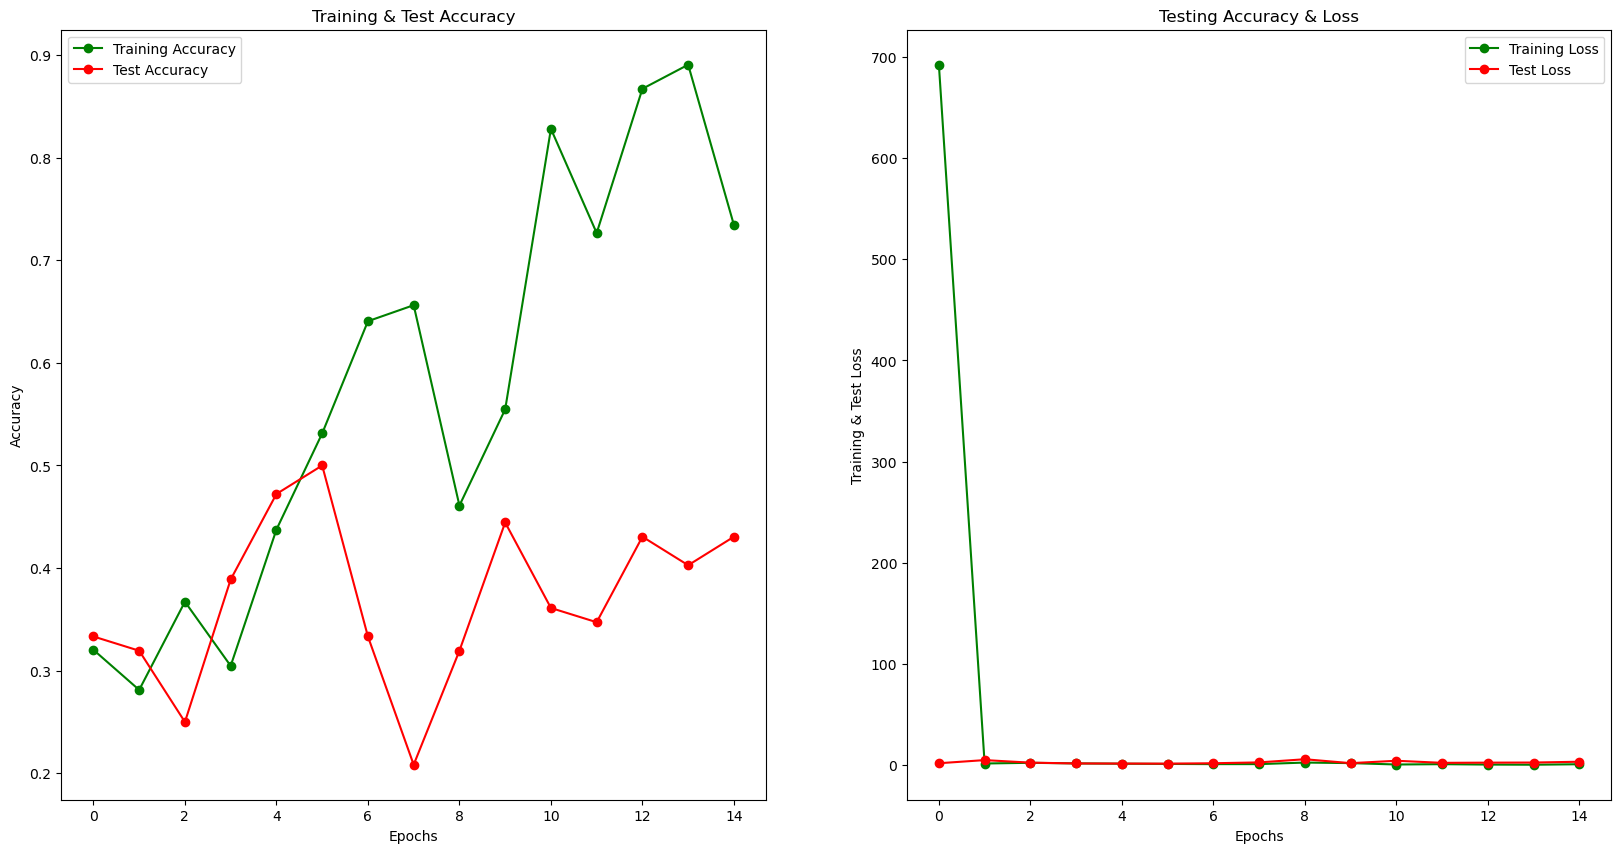

In [25]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = base.history['accuracy']
train_loss = base.history['loss']
test_acc = base.history['val_accuracy']
test_loss = base.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_acc , 'ro-' , label = 'Test Accuracy')
ax[0].set_title('Training & Test Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , test_loss , 'r-o' , label = 'Test Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Test Loss")
plt.show()

The graph shows that the model starts to overfit the training data after the 5th epoch as subsequent rise in accuracy is only seen in the training dataset and not in the test data set. 
The loss function graph shows a sharp fall but is not visually useful as the first loss value is significantly higher than the rest and the scale has been distorted.

The confusion matrix shown below indicates that there is no possible scenario where this model may be of use.

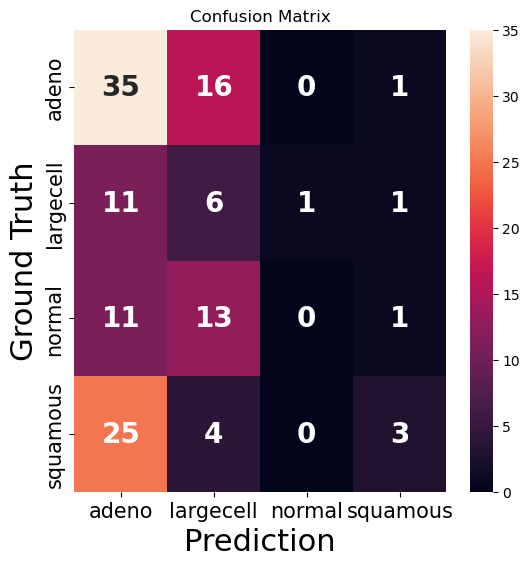

In [26]:
cm_base= confusion_matrix(y_true, classes_y)
fig, ax = plt.subplots(figsize=(6,6))  
ax.set(title = "Confusion Matrix")
sns.heatmap(cm_base,annot =True,ax=ax, annot_kws={"size":20,"weight":"bold"})
labels=["adeno","largecell","normal","squamous"]
ax.set_xticklabels(labels,fontsize =15);
ax.set_yticklabels(labels,fontsize =15);
ax.set_ylabel('Ground Truth',fontsize =22);
ax.set_xlabel('Prediction',fontsize =22);

### 1) Transfer learning

Next we apply transfer learning by using a pretrained model called resnet 50. We use the weigths obtained when the model was trained on the imagenet dataset and then add a few additional fully connected layers to the the resnet50. We train all the layers other than the initial resnet50 model.

In [27]:
from tensorflow.keras.applications import ResNet50

comb_model = Sequential()
comb_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

comb_model.add(Dropout(0.25))
comb_model.add(Flatten())
comb_model.add(Dense(512))
comb_model.add(Activation('relu'))
comb_model.add(Dropout(0.5))
comb_model.add(Dense(num_class))
comb_model.add(Activation('softmax'))

comb_model.layers[0].trainable = False

comb_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                

In [28]:
comb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
m0 = comb_model.fit(x_train,y_train, epochs =15, validation_data=(x_val,y_val),shuffle= True)

Epoch 1/15
4/4 [==============================] - 6s 955ms/step - loss: 2.4974 - accuracy: 0.2578 - val_loss: 1.9538 - val_accuracy: 0.3889
Epoch 2/15
4/4 [==============================] - 2s 442ms/step - loss: 2.1005 - accuracy: 0.4219 - val_loss: 1.1940 - val_accuracy: 0.4583
Epoch 3/15
4/4 [==============================] - 2s 437ms/step - loss: 1.5843 - accuracy: 0.4219 - val_loss: 1.4756 - val_accuracy: 0.3750
Epoch 4/15
4/4 [==============================] - 2s 436ms/step - loss: 1.4147 - accuracy: 0.5234 - val_loss: 1.0228 - val_accuracy: 0.5556
Epoch 5/15
4/4 [==============================] - 2s 442ms/step - loss: 1.2300 - accuracy: 0.5547 - val_loss: 1.0437 - val_accuracy: 0.5139
Epoch 6/15
4/4 [==============================] - 2s 441ms/step - loss: 0.9288 - accuracy: 0.5781 - val_loss: 0.9758 - val_accuracy: 0.5139
Epoch 7/15
4/4 [==============================] - 2s 442ms/step - loss: 0.8174 - accuracy: 0.6484 - val_loss: 0.9913 - val_accuracy: 0.5139
Epoch 8/15
4/4 [====

In [30]:
predict_y_comb=comb_model.predict(x_test)

4/4 [==============================] - 2s 237ms/step


In [31]:
classes_y_comb=np.argmax(predict_y_comb,axis=1)
classes_y_comb

array([2, 3, 3, 3, 2, 3, 2, 2, 3, 1, 0, 3, 3, 3, 0, 2, 3, 3, 3, 2, 2, 3,
       3, 1, 3, 2, 0, 3, 3, 3, 3, 2, 0, 2, 2, 3, 0, 3, 0, 1, 3, 2, 3, 0,
       1, 3, 1, 1, 2, 0, 3, 3, 1, 0, 1, 3, 1, 3, 0, 2, 2, 2, 2, 1, 3, 1,
       2, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 2, 3, 0,
       3, 0, 2, 2, 2, 0, 1, 0, 3, 3, 2, 0, 0, 0, 1, 3, 1, 3, 0, 3, 3, 3,
       1, 3, 3, 3, 0, 3, 0, 0, 2, 3, 3, 1, 1, 3, 1, 3, 0, 1], dtype=int64)

In [32]:
accuracy_score (np.argmax(y_test,axis=1),classes_y_comb)

0.5703125

The accuracy score has drastically improved but is not still high enough for clinical use.

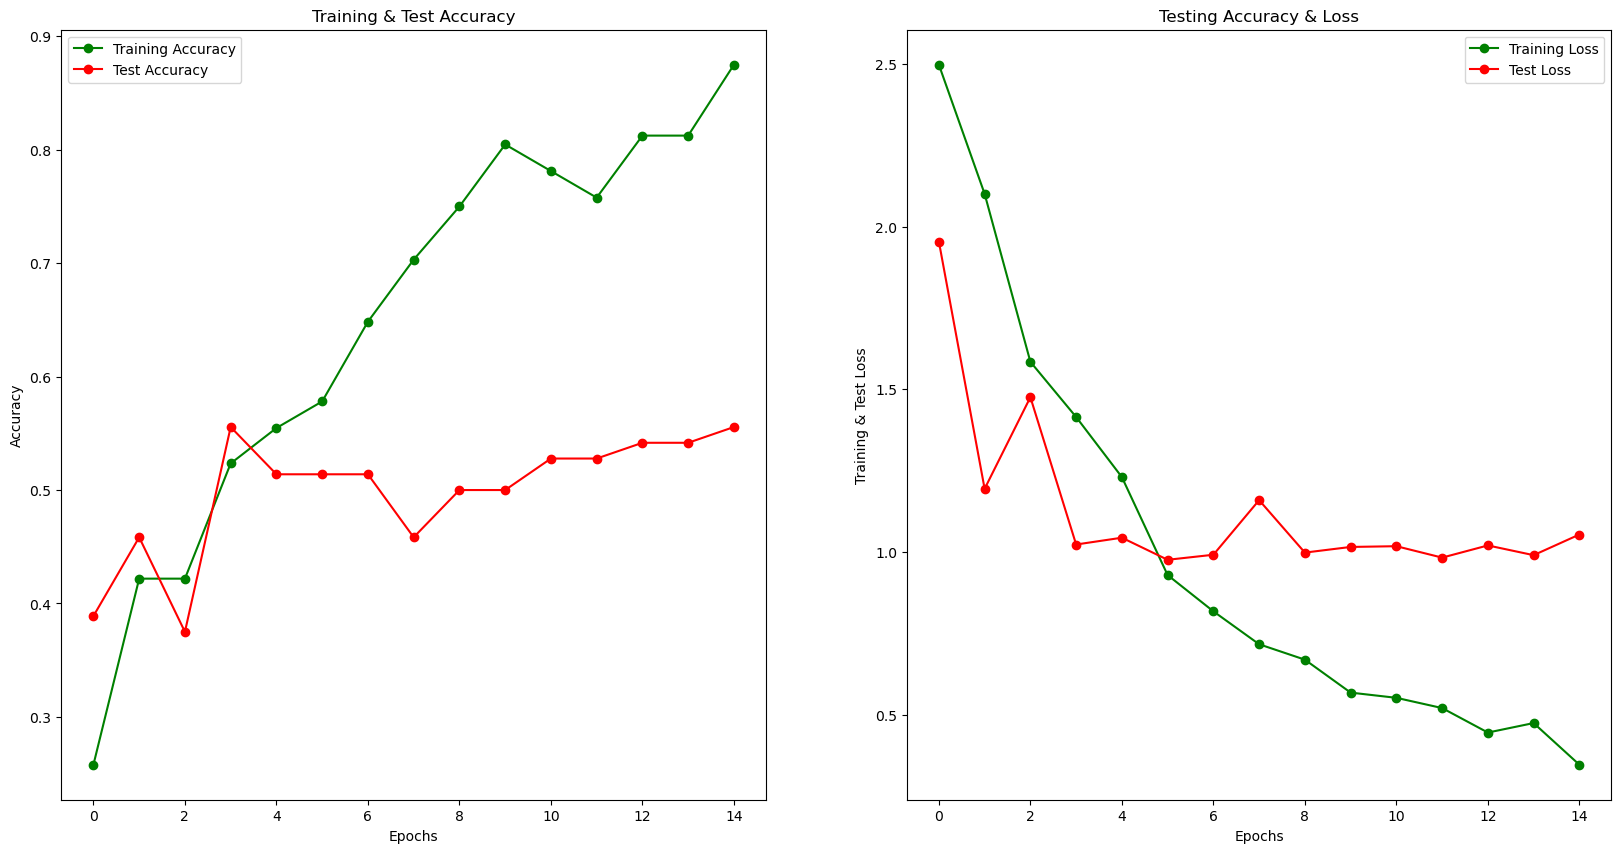

In [33]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = m0.history['accuracy']
train_loss = m0.history['loss']
test_acc = m0.history['val_accuracy']
test_loss = m0.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_acc , 'ro-' , label = 'Test Accuracy')
ax[0].set_title('Training & Test Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , test_loss , 'r-o' , label = 'Test Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Test Loss")
plt.show()

The graph shows that the model starts to overfit the training data after the 5th epoch as subsequent rise in accuracy is only seen in the training dataset and not in the test data set.This is reminiscent of the earlier model. 
The loss function graph shows a steady fall in loss scores for both test an training dataset till the 8th epoch, but in further epochs overfitting is seen on the training dataset.

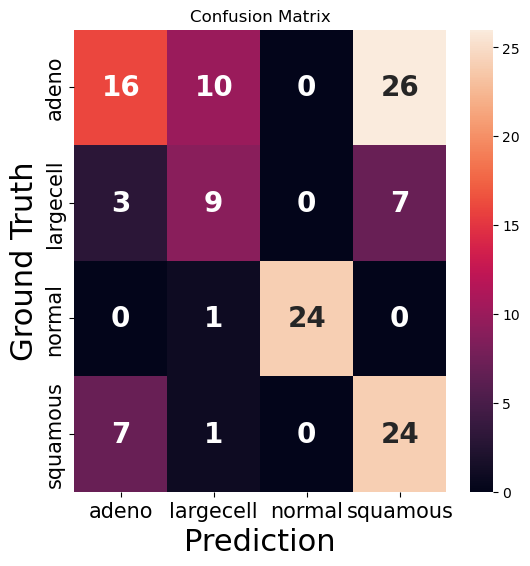

In [34]:
cm1= confusion_matrix(y_true, classes_y_comb)
fig, ax = plt.subplots(figsize=(6,6))  
ax.set(title = "Confusion Matrix")
sns.heatmap(cm1,annot =True,ax=ax, annot_kws={"size":20,"weight":"bold"})
labels=["adeno","largecell","normal","squamous"]
ax.set_xticklabels(labels,fontsize =15);
ax.set_yticklabels(labels,fontsize =15);
ax.set_ylabel('Ground Truth',fontsize =22);
ax.set_xlabel('Prediction',fontsize =22);

The confusion matrix indicates that while the model has trouble predicting the exact type of cancer, it is doing exceptionally well in discriminating between normal vs abnormal CT scans.

### 2) Partial training of the resnet50 model

Now we will be unfreezing the last 15 layers of resnet50 to see if training last few layer of resnet 50 along with the fully connected layer built earlier shall improve the accuracy of the model.

In [35]:
ResNet50 = ResNet50(include_top=False, pooling='avg', weights='imagenet')

In [36]:
ResNet50.trainable = False

for layer in ResNet50.layers[-15:]:
        layer.trainable = True

In [37]:
for i, layer in enumerate(ResNet50.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_2 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [38]:
comb_model1 = Sequential()
comb_model1.add(ResNet50)

comb_model1.add(Dropout(0.25))
comb_model1.add(Flatten())
comb_model1.add(Dense(512))
comb_model1.add(Activation('relu'))
comb_model1.add(Dropout(0.5))
comb_model1.add(Dense(num_class))
comb_model1.add(Activation('softmax'))


comb_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [39]:
comb_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
m1 =comb_model1.fit(x_train,y_train, epochs =15, validation_data=(x_val,y_val),shuffle= True)

Epoch 1/15
4/4 [==============================] - 5s 771ms/step - loss: 2.8985 - accuracy: 0.3203 - val_loss: 1.9541 - val_accuracy: 0.3611
Epoch 2/15
4/4 [==============================] - 2s 442ms/step - loss: 1.8935 - accuracy: 0.3516 - val_loss: 2.0164 - val_accuracy: 0.2917
Epoch 3/15
4/4 [==============================] - 2s 443ms/step - loss: 1.4777 - accuracy: 0.4766 - val_loss: 0.9702 - val_accuracy: 0.4722
Epoch 4/15
4/4 [==============================] - 2s 440ms/step - loss: 1.1262 - accuracy: 0.5625 - val_loss: 1.0460 - val_accuracy: 0.5278
Epoch 5/15
4/4 [==============================] - 2s 449ms/step - loss: 0.9238 - accuracy: 0.6484 - val_loss: 1.8397 - val_accuracy: 0.3056
Epoch 6/15
4/4 [==============================] - 2s 443ms/step - loss: 0.9159 - accuracy: 0.5859 - val_loss: 1.1770 - val_accuracy: 0.4028
Epoch 7/15
4/4 [==============================] - 2s 442ms/step - loss: 0.7629 - accuracy: 0.7031 - val_loss: 1.1977 - val_accuracy: 0.4861
Epoch 8/15
4/4 [====

In [41]:
predict_y_comb1=comb_model1.predict(x_test)

4/4 [==============================] - 2s 235ms/step


In [42]:
classes_y_comb1=np.argmax(predict_y_comb1,axis=1)
classes_y_comb1

array([2, 3, 3, 3, 2, 3, 2, 2, 3, 1, 3, 1, 3, 3, 0, 2, 3, 3, 3, 2, 2, 3,
       3, 1, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2, 2, 3, 0, 3, 3, 1, 3, 2, 3, 0,
       3, 3, 1, 1, 2, 3, 1, 3, 3, 0, 1, 3, 3, 1, 0, 2, 2, 2, 2, 1, 3, 1,
       2, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0,
       3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 0, 1, 3, 1, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 0, 3, 2, 3, 3, 3, 1, 3, 1, 3, 0, 0], dtype=int64)

In [43]:
y_test_arg =np.argmax(y_test,axis=1)
y_test_arg

array([2, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 3, 2, 2, 0,
       3, 1, 0, 2, 3, 3, 3, 0, 3, 2, 0, 2, 2, 0, 0, 1, 3, 0, 3, 2, 0, 0,
       0, 0, 1, 1, 2, 3, 0, 0, 1, 0, 1, 0, 0, 3, 0, 2, 2, 2, 2, 0, 3, 0,
       2, 0, 0, 1, 1, 0, 3, 1, 3, 1, 3, 1, 0, 3, 0, 0, 1, 0, 3, 2, 0, 3,
       0, 0, 2, 2, 2, 3, 1, 0, 0, 3, 2, 0, 3, 0, 0, 3, 0, 3, 0, 3, 3, 1,
       1, 3, 1, 0, 0, 3, 0, 1, 2, 3, 3, 3, 0, 3, 2, 0, 0, 1], dtype=int64)

In [44]:
accuracy_score (y_test_arg,classes_y_comb1)

0.5078125

Unfortunately , we are seeing a small fall in the accuracy score. I was expecting a small increase as the model was now trained/calibrated a bit more towards CT scan images.

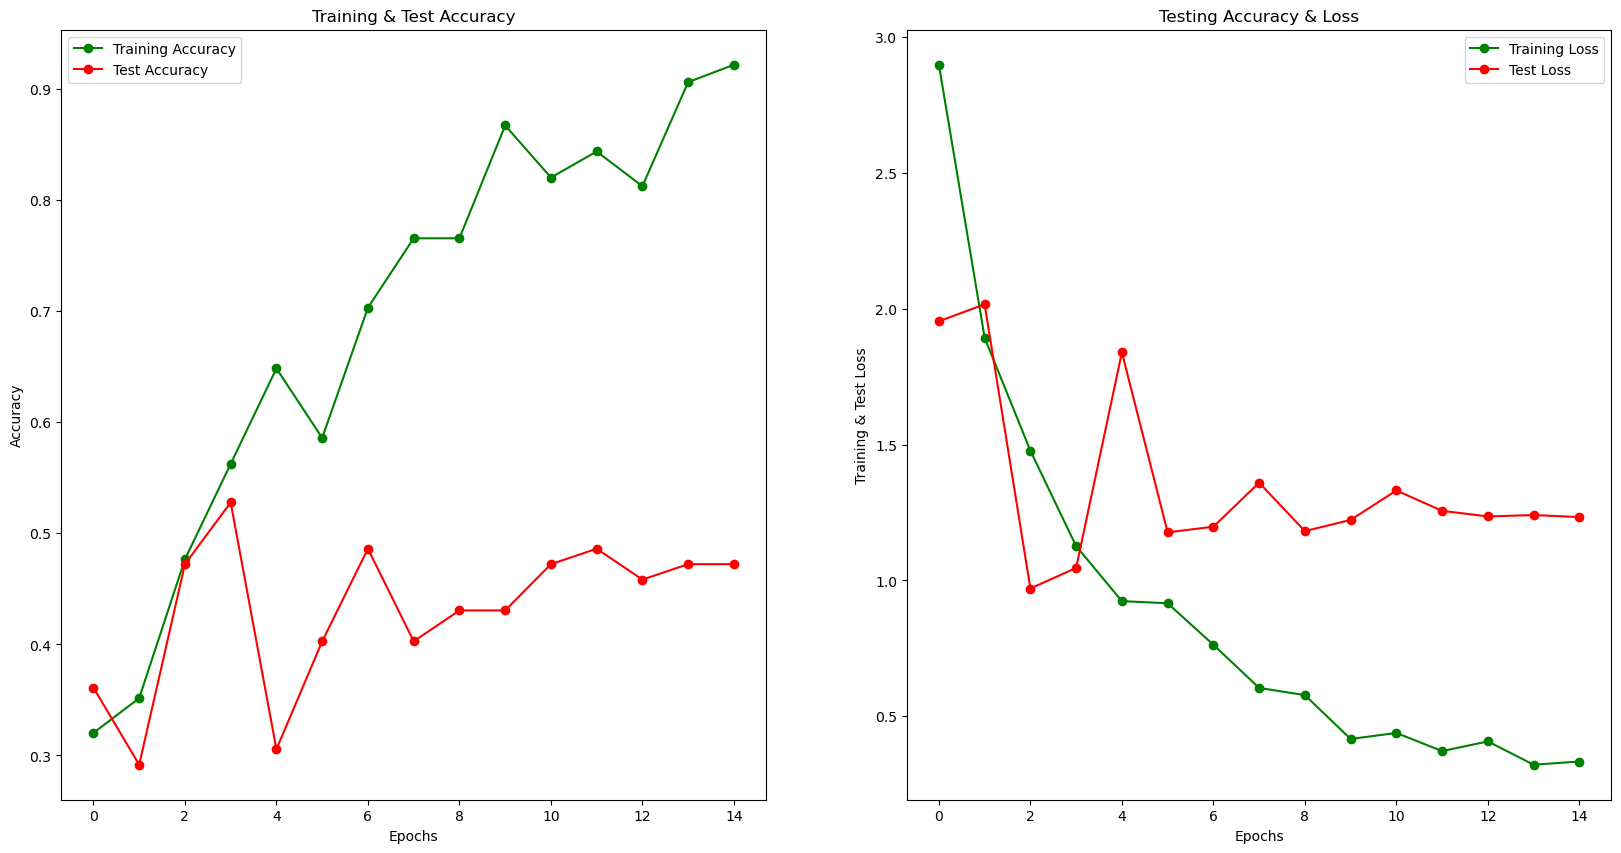

In [45]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = m1.history['accuracy']
train_loss = m1.history['loss']
test_acc = m1.history['val_accuracy']
test_loss = m1.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_acc , 'ro-' , label = 'Test Accuracy')
ax[0].set_title('Training & Test Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , test_loss , 'r-o' , label = 'Test Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Test Loss")
plt.show()

The graph shows that the model starts to overfit the training data after the 2nd epoch as subsequent rise in accuracy is only seen in the training dataset and not in the test data set.This is slightly earier than the previous model. 
The loss function graph shows a steady fall in loss scores for both test an training dataset till the 2th epoch, but in further epochs overfitting is seen on the training dataset, while testing loss spikes.

In [46]:
print(classification_report(y_true, classes_y_comb1,target_names = ['adenocarcinoma (Class 0)','large.cell.carcinoma (Class 1)','normal (Class 2)','squamous.cell.carcinoma (Class 3)']))

                                   precision    recall  f1-score   support

         adenocarcinoma (Class 0)       0.71      0.19      0.30        52
   large.cell.carcinoma (Class 1)       0.22      0.21      0.22        19
                 normal (Class 2)       1.00      0.96      0.98        25
squamous.cell.carcinoma (Class 3)       0.38      0.84      0.52        32

                         accuracy                           0.51       128
                        macro avg       0.58      0.55      0.50       128
                     weighted avg       0.61      0.51      0.48       128



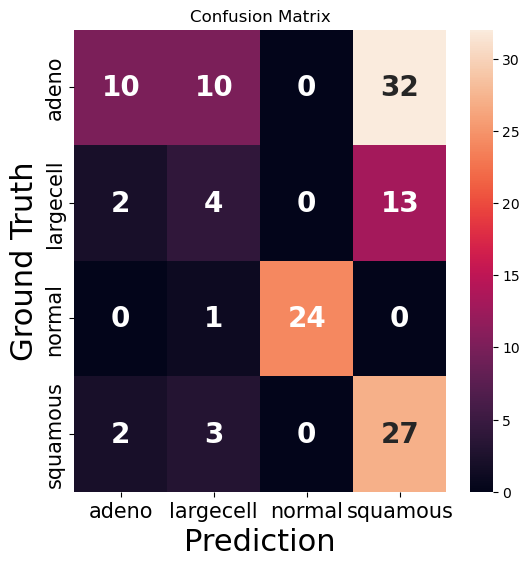

In [47]:

cm2= confusion_matrix(y_true, classes_y_comb1)
fig, ax = plt.subplots(figsize=(6,6))  
ax.set(title = "Confusion Matrix")
sns.heatmap(cm2,annot =True,ax=ax, annot_kws={"size":20,"weight":"bold"})
labels=["adeno","largecell","normal","squamous"]
ax.set_xticklabels(labels,fontsize =15);
ax.set_yticklabels(labels,fontsize =15);
ax.set_ylabel('Ground Truth',fontsize =22);
ax.set_xlabel('Prediction',fontsize =22);

As mentioned earlier, the only usecase here is normal vs cancerous classification and nothing more.

Large cell carcinoma classification seems to be performing the worst, as it has the lowest f1 score. We will look at some of the misclassified large cell ca ct scans and try to guage the cause of missclassification.

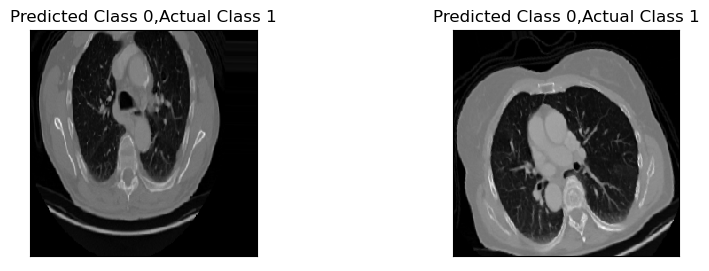

In [48]:
#gen size increases not just 1 output
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

incorrect = np.nonzero((classes_y_comb1 ==0) & (y_test_arg ==1) )[0]

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].astype('uint8'), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(classes_y_comb1 [c], y_test_arg[c]))
    
    i += 1

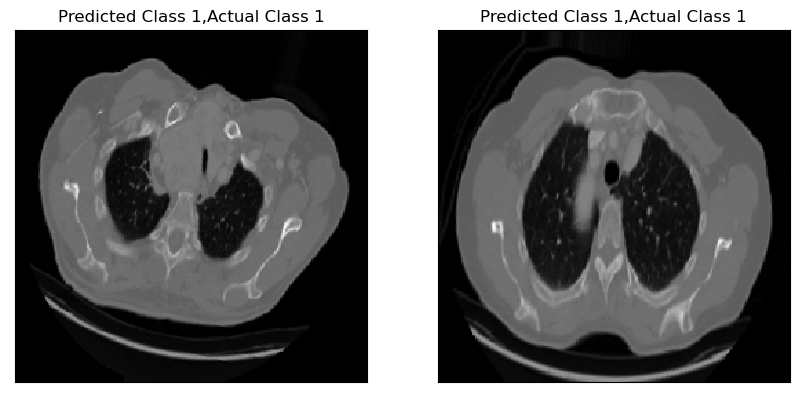

In [49]:
incorrect = np.nonzero((classes_y_comb1 ==1) & (y_test_arg ==1))[0]

i = 0
for c in incorrect[:2]:
    plt.subplot(1,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].astype('uint8'), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(classes_y_comb1 [c], y_test_arg[c]))
    
    i += 1

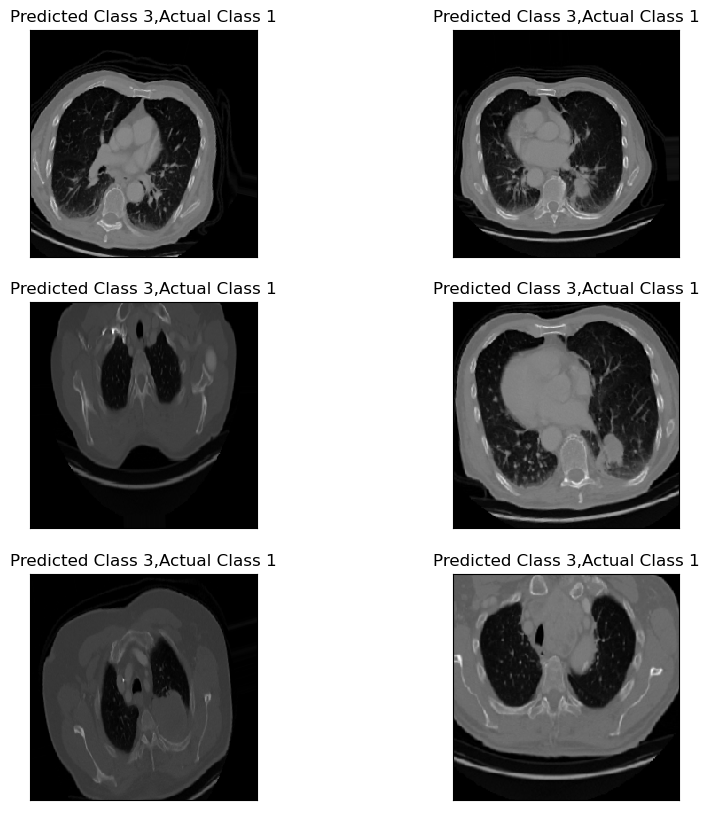

In [50]:
incorrect = np.nonzero((classes_y_comb1 ==3) & (y_test_arg ==1) )[0]

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].astype('uint8'), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(classes_y_comb1 [c], y_test_arg[c]))
    
    i += 1

### 3)Training the entire resnet 50 model from the scratch

Finally I could train the model from scratch but this will require massive computational power and access to more comprehensive datasets , so I have chosen not to do this.



Based on what I have developed so far, this CNN can be used as a screening tool to detect lung cancer during routine/unrelated chest ct scans as it is able to distinguish between normal and abnormal ct scans. But it still performs poorly when trying to differentiate between the different histopathological subtypes.

Model accuracy could be improved by clubbing multiple slices of the ct chest of a patient into a 3D model and then training the model as it would then be able better detect the spatial attributes of the tumor as well as better understand the dimensions of the tumor size. Using more data or better model architecture could also improve the accuracy metrics